<a href="https://colab.research.google.com/github/textnorms/date_text_norm/blob/master/V15-Complete_dates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Sat Jun 20 22:04:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |   2937MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! rm -rf date*
! git clone https://github.com/textnorms/date_text_norm.git
! cp -r date_text_norm/syntetic_data/ .

! pip install -q num2words transformers
! pip install -q transformers

Cloning into 'date_text_norm'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 317 (delta 62), reused 62 (delta 29), pack-reused 211
Receiving objects: 100% (317/317), 1.48 MiB | 1.62 MiB/s, done.
Resolving deltas: 100% (180/180), done.


# Libs

In [ ]:
# Basics
import numpy as np
import pandas as pd
import random

# Synthetic data generator
from syntetic_data import DateTextGenerator
from syntetic_data import RelativeDateTextGenerator

# PyTorch
import torch 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# Transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

# Matplot lib
import matplotlib.pyplot as plt

### Deterministic experiments

In [ ]:
manual_seed = 2357 # only primes, cuz I like
def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Deterministic experiment, seed: {manual_seed}')
    else:
        print('Random experiment')

deterministic()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Deterministic experiment, seed: 2357
Using device: cuda


# Config constants

In [ ]:
# Dataset params
LANGUAGE = 'pt'

# Model params
MODEL_SZ = 't5-small' # 't5-base'
TOK = T5Tokenizer.from_pretrained(MODEL_SZ)
MAX_LEN_SRC  = 48
MAX_LEN_TRGT = 12


# Train params
BATCH_SZ = 16
N_EPOCHS = 50
WINDOW   = 7
NOISE    = 0.0

# Dataset

In [ ]:
pd.set_option('display.max_rows',70)

print('Generating absolute and incomplete dates')
dates = DateTextGenerator(start_date='01/01/1921',
                          end_date='31/12/2120',
                          text_noise_rate=0.0,
                          language=LANGUAGE)

# print('Generating relative dates')
# rel_dates = RelativeDateTextGenerator(n_samples=500, text_noise_rate=0.0,
#                                        max_noise_occurences_per_sample=3,
#                                        samples_per_method=18,
#                                        language=LANGUAGE)

df = dates.generate_date_dataset()
# df = df.append(rel_dates.generate_date_dataset(),ignore_index=True)

Generating absolute and incomplete dates


In [ ]:
examples = dates.generate_demo('27/11/1983','DD/MM/YYYY')

In [ ]:
df.tail()

,Input Pattern,Noise Type,Input,Target,Target Format
82806,20,N/A,"novembro/dois mil, cento e vinte",11/2120,MM/YYYY
82807,17,N/A,"11 dois mil, cento e vinte",11/2120,MM/YYYY
82808,37,N/A,dez . 2120,12/2120,MM/YYYY
82809,15,N/A,"dezembro dois mil, cento e vinte",12/2120,MM/YYYY
82810,3,N/A,"dezembro de dois mil, cento e vinte",12/2120,MM/YYYY


In [ ]:
df['Target Format'].value_counts()

DD/MM/YYYY    73049
MM/YYYY        7200
DD/MM          2562
Name: Target Format, dtype: int64

In [ ]:
# Removing dates in the defined Target Format
df = df.loc[df['Target Format'] == 'DD/MM/YYYY']
print(f'# of patterns: {df["Input Pattern"].nunique()}')
df.head()

# of patterns: 45


,Input Pattern,Noise Type,Input,Target,Target Format
0,34,N/A,01.janeiro.1921,01/01/1921,DD/MM/YYYY
1,1,N/A,dois de janeiro de 1921,02/01/1921,DD/MM/YYYY
2,25,N/A,03 - 01 - 1921,03/01/1921,DD/MM/YYYY
3,20,N/A,"quatro/janeiro/mil, novecentos e vinte e um",04/01/1921,DD/MM/YYYY
4,8,N/A,cinco - 01 - 1921,05/01/1921,DD/MM/YYYY


In [ ]:
# Inspecting the relative dates dataset
df.head()

,Input Pattern,Noise Type,Input,Target,Target Format
0,34,N/A,01.janeiro.1921,01/01/1921,DD/MM/YYYY
1,1,N/A,dois de janeiro de 1921,02/01/1921,DD/MM/YYYY
2,25,N/A,03 - 01 - 1921,03/01/1921,DD/MM/YYYY
3,20,N/A,"quatro/janeiro/mil, novecentos e vinte e um",04/01/1921,DD/MM/YYYY
4,8,N/A,cinco - 01 - 1921,05/01/1921,DD/MM/YYYY


## Function to split the dataset

In [ ]:
def split_data(df, test_size=0.2, verbose=True):
    l = list(set(df['Input Pattern'].values))
    num_test = int(len(l)*test_size)
    test_methods = [random.randint(1, len(l)) for _ in range(num_test)]
    print(test_methods)
    df_test = df[df['Input Pattern'].isin(test_methods)]
    print(df_test.shape)
    x_test = df_test.Input.values
    y_test = df_test.Target.values

    df_train = df[~df['Input Pattern'].isin(test_methods)]

    x_train, x_val, y_train, y_val = train_test_split(
        df_train.Input.values,
        df_train.Target.values,
        shuffle=True, 
        test_size=test_size,
        random_state=manual_seed
        )
    if verbose:
        print(f'Date types of test set: {test_methods} with len: {len(test_methods)}')
        print(f'x_train: {len(x_train)}  --  y_train: {len(y_train)}\n\
x_val:   {len(x_val)}  --  y_val:   {len(y_val)}\n\
x_test:  {len(x_test)}  --  y_test:  {len(y_test)}')

    return x_train, y_train, x_val, y_val, x_test, y_test

# creating sets
x_train, y_train, x_val, y_val, x_test, y_test = split_data(df, 
                                                            test_size=0.25, 
                                                            verbose=True)

[41, 6, 41, 32, 4, 17, 36, 40, 11, 44, 35]
(16459, 5)
Date types of test set: [41, 6, 41, 32, 4, 17, 36, 40, 11, 44, 35] with len: 11
x_train: 42442  --  y_train: 42442
x_val:   14148  --  y_val:   14148
x_test:  16459  --  y_test:  16459


In [ ]:
class DateDataset(Dataset):
    def __init__(self, data, label, tokenizer, source_max_length, target_max_length):
        self.tokenizer = tokenizer
        self.data = data
        self.label = label
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        source = self.data[idx]
        target = self.label[idx]

        source_tokenized = self.tokenizer.encode_plus(
            f'{source} {self.tokenizer.eos_token}',
            max_length=self.source_max_length,
            pad_to_max_length=True,
            return_tensors='pt')

        target_tokenized = self.tokenizer.encode_plus(
            f'{target} {self.tokenizer.eos_token}',
            max_length=self.target_max_length,
            pad_to_max_length=True,
            return_tensors='pt')

        source_token_ids = source_tokenized['input_ids'].squeeze()
        source_mask = source_tokenized['attention_mask'].squeeze()
        target_token_ids = target_tokenized['input_ids'].squeeze()
        
        return source_token_ids, source_mask, target_token_ids

## Checking the DateDataset class

In [ ]:
dataset_debug = DateDataset(
    x_train, 
    y_train,
    TOK,
    MAX_LEN_SRC,
    MAX_LEN_TRGT,
    )

dataloader_checking = DataLoader(
    dataset_debug, 
    batch_size=1, 
    shuffle=True, 
    num_workers=0
    )

source_token_ids, source_mask, target_token_ids = next(iter(dataloader_checking))
print(f'source_token_ids:\n {source_token_ids} --- shape:{source_token_ids.shape}')
print(f'source_mask:\n {source_mask} --- shape:{source_mask.shape}')
print(f'target_token_ids:\n {target_token_ids} --- shape:{target_token_ids.shape}')

source_token_ids:
 tensor([[  285,    29,   776,    20,    20,   776,    51,  5702,    20,   103,
           159, 15533,     6,  3151,    32,     3,    15,    30,   776,     1,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]]) --- shape:torch.Size([1, 48])
source_mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) --- shape:torch.Size([1, 48])
target_token_ids:
 tensor([[  627, 18009, 13311, 15866,     1,     0,     0,     0,     0,     0,
             0,     0]]) --- shape:torch.Size([1, 12])


## Datasets e Dataloaders

In [ ]:
# datasets
ds_debug = DateDataset(x_train[:BATCH_SZ], y_train[:BATCH_SZ], TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_train = DateDataset(x_train, y_train, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_valid = DateDataset(x_val, y_val, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_test  = DateDataset(x_test, y_test, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)

print('Datasets len:')
print(f'len ds_debug: {len(ds_debug)}')
print(f'len ds_train: {len(ds_train)}')
print(f'len ds_valid: {len(ds_valid)}')
print(f'len ds_test:  {len(ds_test)}')

# dataloaders
dataloaders = {
    'debug': DataLoader(
         ds_debug,
         batch_size=BATCH_SZ,
         shuffle=True,
         num_workers=2,
         pin_memory=True),
    'train': DataLoader(
         ds_train,
         batch_size=BATCH_SZ,
         shuffle=True,
         num_workers=2,
         pin_memory=True),
    'valid': DataLoader(
         ds_valid,
         batch_size=BATCH_SZ,
         shuffle=False,
         num_workers=2,
         pin_memory=True),
    'test': DataLoader(
         ds_test,
         batch_size=BATCH_SZ,
         shuffle=False,
         num_workers=2,
         pin_memory=True),
               }
# sanity check
print('\nDataloaders len (in batch):')
dl_sizes = {x: len(dataloaders[x]) for x in dataloaders.keys()}; dl_sizes

Datasets len:
len ds_debug: 16
len ds_train: 42442
len ds_valid: 14148
len ds_test:  16459

Dataloaders len (in batch):


{'debug': 1, 'test': 1029, 'train': 2653, 'valid': 885}

In [ ]:
# testando o dataloader 
source_token_ids, source_mask, target_token_ids = next(iter(dataloaders['debug']))

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_SZ)
    
    def forward(self, token_ids, att_mask, labels):
        outputs = self.model.forward(
            input_ids=token_ids, 
            attention_mask=att_mask,
            lm_labels=labels
            )
        return outputs[0] # loss
    
    @torch.no_grad()    
    def generate(self, token_ids, att_mask, max_len_target):
        predict = self.model.generate(
            input_ids=token_ids, 
            attention_mask=att_mask,
            max_length=max_len_target
            )
        return predict
    
    @torch.no_grad()  
    def generate_example(self, text_input, tokenizer, max_len_source=MAX_LEN_SRC):

        self.model.eval()
        
        example_tokenized = tokenizer.encode_plus(
            f'{text_input} {tokenizer.eos_token}',
            max_length=max_len_source,
            pad_to_max_length=True,
            return_tensors='pt')
            
        example_token_ids = example_tokenized['input_ids']
        example_mask = example_tokenized['attention_mask']

        predicted_example = self.model.generate(
            input_ids=example_token_ids.to(device), 
            attention_mask=example_mask.to(device),
            max_length=MAX_LEN_TRGT
            )

        self.model.train()

        out_text = [tokenizer.decode(text) for text in predicted_example]
        
        return out_text

## Train and evaluation functions

In [ ]:
# acc metric for text inputs
def acc_in_text(trues, preds): 
    acc = []
    for d in zip(trues, preds):
        if d[0] == d[1]:
            acc.append(1)
        else:
            acc.append(0)
    return acc # bool

def train(model, device, train_loader, optimizer):
    loss_train = []
    model.train()
    for source_token_ids, source_mask, target_token_ids in train_loader:
        optimizer.zero_grad()
        loss = model(
            source_token_ids.to(device), 
            source_mask.to(device), 
            target_token_ids.to(device)
            )
        
        loss_train.append(loss.item())
        loss.backward()
        optimizer.step()
    
    train_losses = sum(loss_train) / len(loss_train)
  
    return train_losses

def evaluate_fn(model, device, val_loader, max_len=MAX_LEN_TRGT):
    loss_val, all_acc, all_preds, all_trues = [], [], [], []
    model.eval()
    for source_token_ids, source_mask, target_token_ids in val_loader:
        predicted_ids = model.generate(
            source_token_ids.to(device), 
            source_mask.to(device),
            max_len
            )
        
        preds = [TOK.decode(t) for t in predicted_ids]
        trues = [TOK.decode(t) for t in target_token_ids]
        acc = acc_in_text(trues, preds)
        all_acc.extend(acc)
        all_trues.extend(trues)
        all_preds.extend(preds)
        
        # val loss   
        loss = model(
        source_token_ids.to(device), 
        source_mask.to(device), 
        target_token_ids.to(device)
        )
        loss_val.append(loss.item())
    
    val_losses = sum(loss_val) / len(loss_val)
    
    return val_losses, np.array(all_acc).mean(), all_trues, all_preds

# Overfit in one batch 
- dataloader debug

In [ ]:
overfit = False

if overfit:

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    deterministic() 

    model = Net().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    
    # -----------------------------------------------------------------------------
    start.record()
    for step in range(1, 1001):
        samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
        loss_t = train(model, device, dataloaders['debug'], optimizer)
        loss,acc, trues, preds = evaluate_fn(model, device, dataloaders['debug'])
        if step == 1:
            print(f'[Epoch: {step}/{1000}] |', end=' ')
            print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')
        if step % 100 == 0:
            print(f'[Epoch: {step}/{1000}] |', end=' ')
            print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')
            print(f'  Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')
        if acc>= 0.99:
          print('The model has overfitted! Breaking the loop :)')
          break
    end.record()
    torch.cuda.synchronize()    
    # -----------------------------------------------------------------------------

    print(f'Training time: {start.elapsed_time(end)/1000/60 :.3f} min.')
    del model

# Training 

In [ ]:
try:
  del model
except:
  print('Model already erased, starting a new one!')
  
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
deterministic() 

model = Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

N_EPOCHS = 3

# ---------------------------------------------------------------------------------
start.record()
for step in range(1, N_EPOCHS+1):
    samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
    loss_t = train(model, device, dataloaders['train'], optimizer)
    loss_v, acc, trues, preds = evaluate_fn(model, device, dataloaders['valid'])
    print(f'[Epoch: {step}/{N_EPOCHS}] |', end=' ')
    print(f'Train Loss: {loss_t:.3f} -- Valid Loss: {loss_v:.3f} -- Acc: {acc:.3f}')
    print(f'  Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')

end.record()
torch.cuda.synchronize()    
# ---------------------------------------------------------------------------------

print(f'Training time: {start.elapsed_time(end)/1000/60 :.3f} min.')

Deterministic experiment, seed: 2357
[Epoch: 1/3] | Train Loss: 0.338 -- Valid Loss: 0.023 -- Acc: 0.964
  Trues: ['06/11/2031', '15/01/2005', '10/05/2014', '17/02/2015', '21/03/1924', '15/03/1974', '07/10/1923']
  Preds: ['06/11/2031', '15/01/2005', '10/05/2014', '17/02/2015', '21/03/1924', '15/03/1974', '07/10/1923']
[Epoch: 2/3] | Train Loss: 0.032 -- Valid Loss: 0.004 -- Acc: 0.993
  Trues: ['11/05/2098', '13/06/2113', '18/12/2040', '21/03/2091', '26/12/2117', '31/03/2067', '16/01/2044']
  Preds: ['11/05/2098', '13/06/2113', '18/12/2040', '21/03/2091', '26/12/2117', '31/03/2067', '16/01/2044']
[Epoch: 3/3] | Train Loss: 0.012 -- Valid Loss: 0.002 -- Acc: 0.997
  Trues: ['31/03/2067', '16/01/2044', '06/11/2031', '15/01/2005', '10/05/2014', '17/02/2015', '21/03/1924']
  Preds: ['31/03/2067', '16/01/2044', '06/11/2031', '15/01/2005', '10/05/2014', '17/02/2015', '21/03/1924']
Training time: 13.553 min.


# Test

In [ ]:
# ---------------------------------------------------------------------------------
start.record()

samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
loss, acc, trues, preds = evaluate_fn(model, device, dataloaders['test'])
print(f'Loss: {loss:.3f} -- Acc: {acc:.3f}')
print(f' Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')

end.record()
torch.cuda.synchronize()    
# ---------------------------------------------------------------------------------

print(f'Test time: {start.elapsed_time(end)/1000/60 :.3f} min.')

Loss: 0.050 -- Acc: 0.901
 Trues: ['14/01/1921', '15/01/1921', '17/01/1921', '19/01/1921', '20/01/1921', '21/01/1921', '22/01/1921']
  Preds: ['14/01/1921', '15/01/1921', '17/01/1921', '19/01/1921', '20/01/1921', '21/01/1921', '20/01/1921']
Test time: 1.585 min.


# Evaluating types for a same date

Given a sample date, this section evaluates wich is the accuracy.




In [ ]:
def evaluate_for_a_same_date(date, format, model=model,tokenizer=TOK,verbose=True):
  '''
    Given a specific date, returns the accuracy in all evalueated types.
    Also prints results per sample.
  '''

  results = []
  
#   examples = dates.generate_demo(date=date)
  examples = dates.generate_demo(date,'DD/MM/YYYY')


  for x,target in zip(examples['Generated Text'],examples['Origin Sample']):

    prediction = model.generate_example(x,TOK)[0]

    results.append(prediction == target)

    if verbose:
      print(f'Entrada: {x} -- Target: {target} --- Previsto: {prediction} --- {prediction == target}')

  if verbose:
    print(f'Total accuracy: {np.mean(results)}')

  return np.mean(results)

In [ ]:
'''
  A date in the century with more dates occuring
'''
evaluate_for_a_same_date('11/07/1988','DD/MM/YYYY')

Entrada: onze de julho de 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: onze de jul de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: onze de julho de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: décimo primeiro dia do mês sete de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 20/01/1988 --- False
Entrada: 11 de Julho de 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11 de julho de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11-07 de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: onze - 07 - 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: onze de julho - 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11º de julho de 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 -

0.9777777777777777

In [ ]:
'''
  A date in a century with less dates occurring, but that is inside the
  generated dataset
'''
evaluate_for_a_same_date('20/12/2015','DD/MM/YYYY')

Entrada: vinte de dezembro de 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: vinte de dez de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: vinte de dezembro de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: vigésimo dia do mês doze de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 22/12/2015 --- False
Entrada: 20 de Dezembro de 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20 de dezembro de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20-12 de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: vinte - 12 - 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: vinte de dezembro - 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20º de dezembro de 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20º - 12 - 2015 -- Target: 20/12/2015 --- 

0.9777777777777777

In [ ]:
'''
  Evaluating for a date in a century out of the training range gives the worst
  acc possible. (0)
'''
evaluate_for_a_same_date('25/12/2151','DD/MM/YYYY')

Entrada: vinte e cinco de dezembro de 2151 -- Target: 25/12/2151 --- Previsto: 25/12/251 --- False
Entrada: vinte e cinco de dez de dois mil, cento e cinquenta e um -- Target: 25/12/2151 --- Previsto: 25/12/2101 --- False
Entrada: vinte e cinco de dezembro de dois mil, cento e cinquenta e um -- Target: 25/12/2151 --- Previsto: 25/12/2101 --- False
Entrada: vigésimo quinto dia do mês doze de dois mil, cento e cinquenta e um -- Target: 25/12/2151 --- Previsto: 20/12/2101 --- False
Entrada: 25 de Dezembro de 2151 -- Target: 25/12/2151 --- Previsto: 25/12/251 --- False
Entrada: 25 de dezembro de dois mil, cento e cinquenta e um -- Target: 25/12/2151 --- Previsto: 25/12/2101 --- False
Entrada: 25-12 de dois mil, cento e cinquenta e um -- Target: 25/12/2151 --- Previsto: 25/12/2101 --- False
Entrada: vinte e cinco - 12 - 2151 -- Target: 25/12/2151 --- Previsto: 25/12/251 --- False
Entrada: vinte e cinco de dezembro - 2151 -- Target: 25/12/2151 --- Previsto: 25/12/251 --- False
Entrada: 25º d

0.13333333333333333

In [ ]:
'''
  An earlier date than the beggining of the generated dataset
'''
evaluate_for_a_same_date('27/05/1919','DD/MM/YYYY')

Entrada: vinte e sete de maio de 1919 -- Target: 27/05/1919 --- Previsto: 27/05/1919 --- True
Entrada: vinte e sete de mai de mil, novecentos e dezenove -- Target: 27/05/1919 --- Previsto: 27/05/1919 --- True
Entrada: vinte e sete de maio de mil, novecentos e dezenove -- Target: 27/05/1919 --- Previsto: 27/05/1919 --- True
Entrada: vigésimo sétimo dia do mês cinco de mil, novecentos e dezenove -- Target: 27/05/1919 --- Previsto: 20/05/1919 --- False
Entrada: 27 de Maio de 1919 -- Target: 27/05/1919 --- Previsto: 27/05/1919 --- True
Entrada: 27 de maio de mil, novecentos e dezenove -- Target: 27/05/1919 --- Previsto: 27/05/1919 --- True
Entrada: 27-05 de mil, novecentos e dezenove -- Target: 27/05/1919 --- Previsto: 27/05/1919 --- True
Entrada: vinte e sete - 05 - 1919 -- Target: 27/05/1919 --- Previsto: 27/05/1919 --- True
Entrada: vinte e sete de maio - 1919 -- Target: 27/05/1919 --- Previsto: 27/05/1919 --- True
Entrada: 27º de maio de 1919 -- Target: 27/05/1919 --- Previsto: 27/05/1

0.9555555555555556

# Accuracy in dataset dates

## Inside dataset

Dates into the interval that was used to built the synthetic dataset used for test and eval.

In [ ]:
accs = []
dates_ = []

sampled_test_ = random.sample(df.loc[df['Target Format'] == 'DD/MM/YYYY'].Target.to_list(),50)

print('acc test set: ',sampled_test_)

for date_sample in sampled_test_:
    accs.append(evaluate_for_a_same_date(date_sample,'DD/MM/YYYY', model=model,tokenizer=TOK, verbose=False))
    dates_.append(date_sample)

acc test set:  ['07/04/1933', '05/10/1950', '08/04/2099', '19/06/2058', '22/06/1971', '24/07/2094', '01/04/1982', '10/02/2106', '25/03/2063', '24/02/2081', '02/06/1933', '23/05/1956', '13/12/1936', '13/11/2108', '08/06/2003', '24/04/1959', '09/04/2054', '27/05/2093', '15/11/1929', '09/01/2035', '24/10/2066', '25/09/1936', '09/06/2029', '25/03/2027', '14/12/2001', '03/12/2091', '13/11/2011', '07/05/2003', '08/08/2082', '14/04/1965', '25/12/2110', '27/08/1935', '14/02/2084', '04/09/2068', '17/03/1977', '30/08/1921', '30/09/2050', '07/12/1981', '31/10/1962', '07/06/1996', '09/09/1938', '08/05/2084', '01/12/1967', '11/05/1969', '17/05/1965', '28/01/1986', '15/04/2057', '22/05/1929', '07/04/2114', '03/04/1965']


Average of average accuracies:  0.9813333333333334


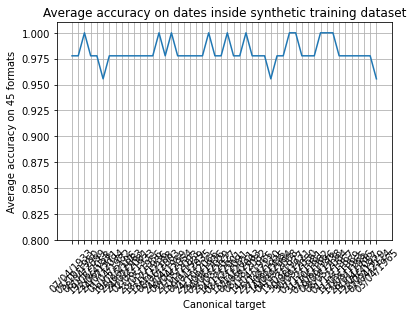

In [ ]:
plt.plot(dates_,accs)
plt.xticks(rotation=45)
plt.grid()
plt.ylim([0.8, 1.01])
plt.ylabel('Average accuracy on 45 formats')
plt.xlabel('Canonical target')
plt.title('Average accuracy on dates inside synthetic training dataset')
print('Average of average accuracies: ',np.mean(accs))

## Below dataset

Dates lower than the synthetic dataset used for test and eval.

In [ ]:
accs = []
dates_ = []

new_dataset = DateTextGenerator(start_date='01/01/1900',
                                end_date='31/12/1920',
                                text_noise_rate=NOISE,
                                language=LANGUAGE
                                )
new_df = new_dataset.generate_date_dataset()

sampled_test_ = random.sample(new_df.loc[new_df['Target Format'] == 'DD/MM/YYYY'].Target.to_list(),50)

print('acc test set: ',sampled_test_)

for date_sample in sampled_test_:
    accs.append(evaluate_for_a_same_date(date_sample,'DD/MM/YYYY', model=model,tokenizer=TOK, verbose=False))
    dates_.append(date_sample)

acc test set:  ['13/12/1907', '06/09/1909', '24/01/1911', '21/04/1913', '18/09/1906', '19/04/1918', '11/09/1913', '28/02/1905', '10/06/1917', '26/11/1909', '15/02/1917', '12/03/1916', '07/10/1917', '31/10/1911', '26/08/1913', '02/06/1917', '27/08/1919', '23/12/1920', '21/06/1903', '29/06/1900', '24/08/1911', '02/08/1911', '15/09/1902', '03/12/1912', '01/10/1909', '15/04/1914', '01/02/1916', '03/10/1906', '14/12/1918', '28/10/1918', '13/04/1907', '11/02/1920', '01/06/1908', '28/06/1908', '05/10/1912', '05/01/1906', '22/12/1901', '11/03/1900', '08/04/1910', '17/11/1916', '07/06/1920', '30/08/1920', '29/11/1909', '13/04/1906', '15/09/1914', '01/10/1906', '29/07/1903', '13/08/1907', '22/05/1903', '12/07/1909']


Average of average accuracies:  0.804


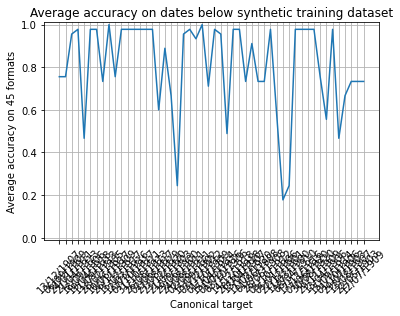

In [ ]:
plt.plot(dates_,accs)
plt.xticks(rotation=45)
plt.grid()
plt.ylim([-0.01, 1.01])
plt.ylabel('Average accuracy on 45 formats')
plt.xlabel('Canonical target')
plt.title('Average accuracy on dates below synthetic training dataset')
print('Average of average accuracies: ',np.mean(accs))

## Above dataset

Dates greater than the synthetic dataset used for test and eval.

In [ ]:
accs = []
dates_ = []

new_dataset = DateTextGenerator(start_date='01/01/2121',
                                end_date='31/12/2140',
                                text_noise_rate=NOISE,
                                language=LANGUAGE
                                )

new_df = new_dataset.generate_date_dataset()

sampled_test_ = random.sample(new_df.loc[new_df['Target Format'] == 'DD/MM/YYYY'].Target.to_list(),50)

print('acc test set: ',sampled_test_)

for date_sample in sampled_test_:
    accs.append(evaluate_for_a_same_date(date_sample,'DD/MM/YYYY', model=model,tokenizer=TOK, verbose=False))
    dates_.append(date_sample)

acc test set:  ['11/10/2129', '09/08/2133', '14/12/2127', '27/10/2133', '20/06/2129', '15/05/2133', '28/03/2131', '31/07/2135', '29/06/2131', '04/06/2124', '18/11/2129', '25/07/2134', '28/12/2137', '27/10/2121', '13/09/2124', '19/11/2127', '17/07/2126', '15/04/2136', '04/09/2136', '08/09/2126', '25/02/2129', '30/08/2133', '12/04/2134', '29/07/2136', '21/09/2123', '04/03/2130', '09/01/2130', '24/05/2125', '18/06/2126', '04/09/2134', '15/04/2127', '22/05/2127', '23/03/2131', '24/11/2131', '25/03/2138', '30/01/2127', '04/01/2129', '14/03/2128', '07/09/2137', '05/08/2122', '17/03/2132', '17/02/2124', '09/02/2138', '12/11/2122', '31/12/2129', '03/05/2126', '14/01/2132', '15/09/2123', '23/09/2126', '12/03/2124']


Average of average accuracies:  0.6204444444444445


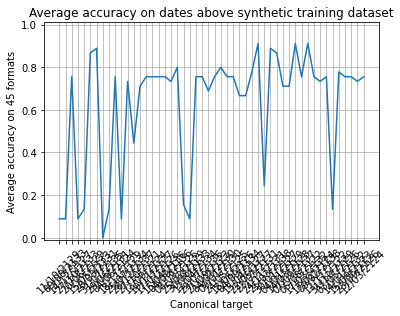

In [ ]:
plt.plot(dates_,accs)
plt.xticks(rotation=45)
plt.grid()
plt.ylim([-0.01, 1.01])
plt.ylabel('Average accuracy on 45 formats')
plt.xlabel('Canonical target')
plt.title('Average accuracy on dates above synthetic training dataset')
print('Average of average accuracies: ',np.mean(accs))

# The End